In [1]:
# Loading the Packages
%reload_ext autoreload
%autoreload 2

import os
# important for gpd.sjoin
os.environ["USE_PYGEOS"] = "0"

from pathlib import Path
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import igraph
import random
import math
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",      # 使用 XeLaTeX，如果不需要 LaTeX 公式渲染，可以省略
    'font.family': 'serif',          # 字体设置为衬线字体
    'text.usetex': False,            # 禁用 LaTeX，使用 Matplotlib 内置文字渲染
    'pgf.rcfonts': False,            # 禁用 pgf 的默认字体管理
    'pdf.fonttype': 42,              # 确保字体为 TrueType 格式，可被 Illustrator 编辑
    'ps.fonttype': 42,               # EPS 文件也使用 TrueType 格式
    'figure.dpi': 300,               # 设置图形分辨率
    'savefig.dpi': 300,              # 保存的图形文件分辨率
    'axes.unicode_minus': False,     # 避免负号问题
})

In [2]:
# workdir 
BASE_DIR = Path(r'G:\spatial_data')
RUN_ID = '20230523_HCC_PRISM_probe_refined'
src_dir = BASE_DIR / 'processed' / RUN_ID

# Load one slide exp
data_path = src_dir / "segmented"

# analysis dir
analysis_dir = BASE_DIR / 'analysis' / RUN_ID
typ_path = analysis_dir / "cell_typing"

output_path = analysis_dir / "interaction_graph"
output_path.mkdir(exist_ok=True)

In [119]:
def get_interaction_matrix(adata, cluster_key, spatial_key, normalized):
    """
    Get the interaction matrix for a given batch of cells using Squidpy.

    Parameters
    - adata (anndata): The anndata object containing the cells to find interactions between.
    - cluster_key (str): The key in adata.obs to use for defining discrete interacting groups.
    - spatial_key (str): The key in adata.obsm to use for spatial coordinates.
    - normalized (bool): Whether to normalize the interaction matrix.

    Returns
    - interaction_matrix (np.ndarray): The interaction matrix.
    """

    adata = adata.copy()
    sq.gr.spatial_neighbors(adata, spatial_key=spatial_key)
    sq.gr.interaction_matrix(adata, cluster_key=cluster_key, normalized=normalized)

    return adata.uns[f"{cluster_key}_interactions"]


def mean_interaction_matrix(adata, batches, cluster_key, spatial_key="X_spatial", normalized=True):
    """
    Get the mean interaction matrix for a set of batches of cells using Squidpy.

    Parameters
    - adata (anndata): The anndata object containing the cells to find interactions between.
    - batches (list): The list of batch names to use in the interaction analysis.
    - cluster_key (str): The key in adata.obs to use for defining discrete interacting groups.
    - spatial_key (str): The key in adata.obsm to use for spatial coordinates.
    - normalized (bool): Whether to normalize the interaction matrix.

    Returns
    - mean_interactions (np.ndarray): The mean interaction matrix.
    """

    interactions = [
        get_interaction_matrix(
            adata=adata[adata.obs["batch"] == b],
            spatial_key=spatial_key,
            cluster_key=cluster_key,
            normalized=normalized,
        )
        for b in batches
    ]

    mean_interactions = sum(interactions) / len(batches)

    return mean_interactions


def create_mean_interaction_graph(adata, batches, cluster_key, spatial_key="spatial", interaction_cutoff=0.05):
    """
    Create an interaction graph for a set of batches of cells using Squidpy.

    Parameters
    - adata (anndata): The anndata object containing the cells to find interactions between.
    - batches (list): The list of batch names to use in the interaction analysis.
    - cluster_key (str): The key in adata.obs to use for defining discrete interacting groups.
    - spatial_key (str): The key in adata.obsm to use for spatial coordinates.
    - interaction_cutoff (float): The cutoff for interactions to be included in the graph.

    Returns
    - g (igraph.Graph): The interaction graph.
    """

    M = mean_interaction_matrix(adata=adata, batches=batches, cluster_key=cluster_key, spatial_key=spatial_key)
    M[M < interaction_cutoff] = 0
    g = igraph.Graph.Weighted_Adjacency(M)
    g.vs["label"] = adata.obs[cluster_key].cat.categories
    return g


# def get_mean_expression(adata, batches, gene, cluster_key):
#     """
#     Calculate the mean expression of specified genes for each batch and gate in the provided AnnData object.

#     Parameters:
#     - adata (AnnData): Annotated data matrix with observations (rows) and variables (columns).
#     - gene (str): A gene name for which mean expression is calculated.

#     Returns:
#     - pd.DataFrame: A DataFrame containing mean expression values for the gene, batch.
#     """
#     import re

#     adata = adata[adata.obs.batch.isin(batches)]
#     keys = [gene, "batch", cluster_key]
#     df = sc.get.obs_df(adata, keys=keys)
#     grouped = df.groupby(["batch", cluster_key]).mean().reset_index()
#     grouped = grouped[[cluster_key, gene]].groupby(cluster_key).mean().reset_index()
#     expression = grouped[gene].tolist()
#     expression = expression / np.max(expression)
#     return expression

In [120]:
def plot_graph(g, vertex_colors, ax, layout="kk", highlight="Cd8_T-Cell_P14"):
    """
    Plot an igraph graph with specified vertex colors and layout.

    Parameters
    - g (igraph.Graph): The graph to plot.
    - vertex_colors (list): The list of colors to use for the vertices.
    - ax (matplotlib.axes.Axes): The axes to plot the graph on.
    - layout (str): The layout to use for the graph.
    - highlight (str): The vertex to highlight in the graph.

    Returns
    - None
    """

    random.seed(42)
    try:
        node = g.vs["label"].index(highlight)
        highlight_edges = g.incident(node, "all")
    except:
        highlight_edges = []

    edge_color = [
        "90,10,0" if i in highlight_edges else "0,0,0" for i in range(len(g.es))
    ]
    igraph.plot(
        g,
        target=ax,
        layout=layout,
        # edge_color=[f"rgba({c}, {w})" for c, w in zip(edge_color, scale_numbers(g.es["weight"]))],
        edge_color=[f"rgba({c}, 0.8)" for c in edge_color],
        # edge_color=[f"rgba({c}, {w})" for c, w in zip(edge_color, 
        #             scale_numbers(g.es["weight"], target_min=0.1, target_max=10))],
        edge_arrow_size=0.5,
        # edge_width=2,
        edge_width=np.log10(scale_numbers(g.es["weight"], target_min=10, target_max=1000)),
        vertex_color=vertex_colors,
        vertex_label_dist=-1,
        vertex_label_size=1,
        edge_loop_angle=np.pi, 
        edge_loop_size=80)


def scale_numbers(input_list, target_min=0.1, target_max=10):
    """
    Scale a list of numbers to a target range.

    Parameters
    - input_list (list): The list of numbers to scale.
    - target_min (float): The minimum value of the target range.
    - target_max (float): The maximum value of the target range.

    Returns
    - scaled_list (list): The list of scaled numbers.
    """

    # Find the minimum and maximum values in the input list
    min_value = min(input_list)
    max_value = max(input_list)

    # Scale each number in the input list to the target range
    scaled_list = [
        ((x - min_value) / (max_value - min_value)) * (target_max - target_min)
        + target_min
        for x in input_list
    ]

    return scaled_list


# def ceil_division(numerator, denominator):
#     return int(math.ceil(numerator / denominator))


def global_layout(adata, cluster_key, batches, spatial_key='spatial', layout="kk", interaction_cutoff=0.05):
    """
    Create a global layout for the cells in an AnnData object using an interaction graph.

    Parameters
    - adata (anndata): The AnnData object containing the cells to create a layout for.
    - cluster_key (str): The key in adata.obs to use for defining discrete interacting groups.
    - batches (list): The list of batch names to use in the interaction analysis.
    - layout (str): The layout to use for the graph.

    Returns
    - layout (igraph.Layout): The global layout for the cells in the AnnData object.
    """

    g = create_mean_interaction_graph(adata, batches, cluster_key, spatial_key=spatial_key, interaction_cutoff=interaction_cutoff)
    random.seed(42)
    layout = g.layout(layout)
    return layout

## nhood all

In [6]:
# combine_adata_st = sc.read_h5ad(typ_path / 'combine_adata_st.h5ad')
# adata_direct = sc.read_h5ad(typ_path / 'adata_leiden_res_1.h5ad')
# adata = adata_direct[adata_direct.obs.index.isin(combine_adata_st.obs.index)]
# adata.obs = combine_adata_st.obs

# # format for later analysis
# adata.obs = adata.obs.rename(columns={'X_pos':'X', 'Y_pos':'Y'})
# adata.obsm['spatial'] = adata.obs.loc[:, ['X', 'Y']].values
# adata.obs['batch'] = adata.obs['dataset']
# adata = adata[adata.obs['type'] != 'other']
# print(adata)
# adata.obs.head()

adata = sc.read_h5ad(typ_path / 'adata.h5ad')
adata = adata[adata.obs['type'] != 'other']
adata.obs['batch'] = adata.obs['dataset']

In [7]:
batches = {"2D": ["PRISM_HCC"]}
all_batches = list(np.concatenate(list(batches.values())))

### Make the interaction graph, colored by celltype

In [239]:
import yaml
with open(analysis_dir / 'cell_typing_params.yaml') as file: annotaiton_params = yaml.load(file, Loader=yaml.FullLoader)
leiden_annotation = annotaiton_params['leiden_annotation']
leiden_type_dict = {}
leiden_subtype_dict = {}
for type_key, subtypes in leiden_annotation.items():
    type_values = []
    for subtype_key, values in subtypes.items():
        type_values.extend(values)
        leiden_subtype_dict[subtype_key] = values
    leiden_type_dict[type_key] = type_values

type_colormap = annotaiton_params['type_colormap']
subtype_colormap = dict()
for subtype in leiden_subtype_dict.keys():
    for rough_type in type_colormap.keys():
        if rough_type in subtype:
            subtype_colormap[subtype] = type_colormap[rough_type]
            break
subtype_colormap

{'Liver': [1, 0.392, 0],
 'Tumor_AFP+': [0.751, 0.491, 0],
 'Tumor_GPC3+': [0.751, 0.491, 0],
 'Tumor_proliferation': [0.751, 0.491, 0],
 'other_cell_proliferation': [0, 0.5, 0.636],
 'Endo_PECAM1+': [1, 0, 1],
 'Ep_EPCAM+': [0, 1, 0],
 'CAF_ACTA2+': [0, 0, 1],
 'cDC1_CLEC9A+': [1, 0.259, 0],
 'cDC2_CD1C+': [1, 0.259, 0],
 'pDC_LILRA4+': [1, 0.259, 0],
 'Mait_SLC4A10+': [1, 0, 0.434],
 'Mast_CPA3+': [1, 0, 0],
 'Monocyte_CD14+': [0, 0.471, 1],
 'Monocyte_CD14+, CD16+': [0, 0.471, 1],
 'Monocyte_CD16+': [0, 0.471, 1],
 'Neutrophil_CSF3R+, S100A8+': [1, 1, 0],
 'Neutrophil_CSF3R+': [1, 1, 0],
 'Macrophage_LYVE1+': [0.5, 0.8, 0],
 'Macrophage_C1QA+': [0.5, 0.8, 0],
 'Cyto_T_CD4+': [0.5, 0.5, 0.5],
 'T_CD4+, PD1+': [0.5, 0.5, 0.5],
 'T_CD4+, CXCL13+': [0.5, 0.5, 0.5],
 'T_CD4+, PD1+, CTLA4+': [0.5, 0.5, 0.5],
 'T_CD4+, CTLA4+': [0.5, 0.5, 0.5],
 'Cyto_T_CD8+': [1, 0.8, 0],
 'T_CD8+, PD1+': [1, 0.8, 0],
 'T_CD8+, CTLA4+': [1, 0.8, 0],
 'T_CD8+, GZMA+, CXCL13+': [1, 0.8, 0],
 'T_reg': [0, 1,

In [ ]:
leiden_annotation = annotaiton_params['leiden_annotation']
leiden_type_dict = {}
leiden_subtype_dict = {}
for type_key, subtypes in leiden_annotation.items():
    type_values = []
    for subtype_key, values in subtypes.items():
        type_values.extend(values)
        leiden_subtype_dict[subtype_key] = values
    leiden_type_dict[type_key] = type_values

type_colormap = annotaiton_params['type_colormap']
subtype_colormap = dict()
for subtype in leiden_subtype_dict.keys():
    for rough_type in type_colormap.keys():
        if rough_type in subtype:
            subtype_colormap[subtype] = type_colormap[rough_type]
            break
subtype_colormap

In [8]:
# We have defined colors for the Type but not the Subtype annotation. Hence, we will create a assignment
# from subtype to type to pick the colors.
subtype_to_type = (adata.obs.groupby(["subtype", "type"]).size().reset_index().rename(columns={0: "count"}))
subtype_to_type = subtype_to_type[subtype_to_type["count"] > 0].set_index("subtype")

In [10]:
# interaction_cutoff = 0.01
# ncols = len(batches.keys())
# fig, axes = plt.subplots(1, ncols, figsize=(6, 6))
# for col, batch in enumerate(batches.keys()):
#     g = create_mean_interaction_graph(adata=adata, batches=batches[batch], cluster_key="subtype", interaction_cutoff=interaction_cutoff)
#     if ncols == 1: ax = axes
#     else: ax = axes[col]
#     node_colors = [type_colormap[subtype_to_type["type"].loc[t]] for t in adata.obs["subtype"].cat.categories]
#     plot_graph(g=g, vertex_colors=node_colors, ax=ax, layout='kk')
#     ax.set_title(f"{batch}: subtype, interaction_cutoff={interaction_cutoff}")
# fig.tight_layout()
# plt.show()

In [ ]:
# # # initial layout
# interaction_cutoff = 0.05
# gl = global_layout(adata=adata, cluster_key="subtype", batches=["PRISM_HCC"], interaction_cutoff=interaction_cutoff)

# # batch test
# for iter in range(21):
#     interaction_cutoff = 0.01 * iter
#     ncols = len(batches.keys())
#     fig, axes = plt.subplots(1, ncols, figsize=(9 * ncols, 6 * 1))

#     for col, batch in enumerate(batches.keys()):
#         g = create_mean_interaction_graph(adata=adata, batches=batches[batch], cluster_key="subtype", interaction_cutoff=interaction_cutoff)
#         if ncols == 1: ax = axes
#         else: ax = axes[col]
#         node_colors = [type_colormap[subtype_to_type["type"].loc[t]] for t in adata.obs["subtype"].cat.categories]
#         plot_graph(g=g, vertex_colors=node_colors, ax=ax, layout=gl)
#         ax.set_title(f"{batch}: subtype, interaction_cutoff={interaction_cutoff}")
#     fig.tight_layout()
#     plt.savefig(output_path / f"subtype_interaction_graph_cutoff={iter}x0.01.png", bbox_inches='tight', dpi=300)
#     plt.close()

In [121]:
# # initial layout
interaction_cutoff = 0.05
gl = global_layout(adata=adata, cluster_key="subtype", batches=["PRISM_HCC"], interaction_cutoff=interaction_cutoff)

# batch test
iter = 6
interaction_cutoff = 0.01 * iter
ncols = len(batches.keys())
fig, axes = plt.subplots(1, ncols, figsize=(15, 10))

for col, batch in enumerate(batches.keys()):
    g = create_mean_interaction_graph(adata=adata, batches=batches[batch], cluster_key="subtype", interaction_cutoff=interaction_cutoff)
    if ncols == 1: ax = axes
    else: ax = axes[col]
    node_colors = [type_colormap[subtype_to_type["type"].loc[t]] for t in adata.obs["subtype"].cat.categories]
    plot_graph(g=g, vertex_colors=node_colors, ax=ax, layout=gl)
    ax.set_title(f"{batch}: subtype, interaction_cutoff={interaction_cutoff}")

handles = []
for subtype, color in type_colormap.items():
    handles.append(plt.Line2D([0], [0], marker="o", color="w", label=subtype, markerfacecolor=color, markersize=10))
# ax.legend(
#         handles=handles,
#         loc="upper left",
#         bbox_to_anchor=(1.05, 1),
#         borderaxespad=0,
#         frameon=False,
#     )

fig.tight_layout()
plt.savefig(output_path / f"subtype_interaction_graph_cutoff={iter}x0.01_revised.pdf", bbox_inches='tight', dpi=300)
plt.close()
# plt.show()

In [ ]:
adata

AnnData object with n_obs × n_vars = 60329 × 31
    obs: 'dataset', 'n_genes', 'n_counts', 'leiden_type', 'type', 'leiden_subtype', 'subtype', 'batch'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
cluster_key = "subtype"
spatial_key = "spatial"

cats = adata.obs[cluster_key]
mask = ~pd.isnull(cats).values
cats = cats.loc[mask]


# adata = adata.copy()
sq.gr.spatial_neighbors(adata, spatial_key=spatial_key)

In [259]:
sq.gr.interaction_matrix(adata, cluster_key=cluster_key, normalized=True)
interaction_matrix = adata.uns[f"{cluster_key}_interactions"]
categories = cats.cat.categories
interaction_matrix = pd.DataFrame(interaction_matrix, index=categories, columns=categories)
interaction_matrix.loc[['Tumor_AFP+', 'pDC_LILRA4+', 'T_CD4+, CXCL13+'],['Tumor_AFP+', 'pDC_LILRA4+', 'T_CD4+, CXCL13+']]

,Tumor_AFP+,pDC_LILRA4+,"T_CD4+, CXCL13+"
Tumor_AFP+,0.396605,0.018222,0.031248
pDC_LILRA4+,0.070306,0.035611,0.048180
"T_CD4+, CXCL13+",0.060031,0.024038,0.095960


In [ ]:
# interaction_matrix[interaction_matrix < 0.06] = 0
# g = igraph.Graph.Weighted_Adjacency(interaction_matrix)
# g.vs["label"] = adata.obs[cluster_key].cat.categories
# fig, ax = plt.subplots(figsize=(10, 10))
# igraph.plot(g,target=ax,)
# plt.show()

In [275]:
interaction_matrix_tmp = interaction_matrix.copy()
interaction_matrix_tmp[interaction_matrix_tmp < 0.06] = 0
interaction_matrix_tmp.sort_values(inplace=True, by='Tumor_AFP+', ascending=False)
# sns.barplot(interaction_matrix_tmp['Tumor_AFP+'])
tmp_data = np.log1p(interaction_matrix_tmp['Tumor_AFP+'].iloc[1:])
plt.figure(figsize=(10, 5))
sns.barplot(tmp_data, palette=[(0.8,0,0)]*len(tmp_data), width=0.6)
# plt.xticks(range(len(interaction_matrix_tmp.index)), interaction_matrix_tmp.index, rotation=90)
plt.xticks(rotation=90)
plt.ylabel('Normalized Number of Neighbors')
plt.title('AFP+ Tumor')
plt.tight_layout()
plt.savefig(output_path / f"Normalized_Number_of_Neighbors_AFP+_Tumor_thre_only.pdf")
plt.close()

In [274]:
interaction_matrix_tmp = interaction_matrix.copy()
interaction_matrix_tmp.sort_values(inplace=True, by='Tumor_AFP+', ascending=False)
# sns.barplot(interaction_matrix_tmp['Tumor_AFP+'])
tmp_data = np.log1p(interaction_matrix_tmp['Tumor_AFP+'].iloc[1:])
plt.figure(figsize=(10, 5))
sns.barplot(tmp_data, palette=[(0.8,0,0)]*len(tmp_data[tmp_data>=np.log1p(0.06)])+[(0.5,0.5,0.5)]*len(tmp_data[tmp_data<np.log1p(0.06)]), width=0.6)
# plt.xticks(range(len(interaction_matrix_tmp.index)), interaction_matrix_tmp.index, rotation=90)
plt.xticks(rotation=90)
plt.ylabel('Normalized Number of Neighbors')
plt.title('AFP+ Tumor')
plt.tight_layout()
plt.savefig(output_path / f"Normalized_Number_of_Neighbors_AFP+_Tumor.pdf")
plt.close()

In [82]:
adata.obs[cluster_key].cat.categories

Index(['B_CD79A+', 'B_CD79A+, MS4A1+', 'B_MS4A1+', 'CAF_ACTA2+', 'Cyto_T_CD4+',
       'Cyto_T_CD8+', 'Endo_PECAM1+', 'Ep_EPCAM+', 'Liver', 'Macrophage_C1QA+',
       'Macrophage_LYVE1+', 'Mait_SLC4A10+', 'Mast_CPA3+', 'Monocyte_CD14+',
       'Monocyte_CD14+, CD16+', 'Monocyte_CD16+', 'NK_NCAM1+',
       'Neutrophil_CSF3R+', 'Neutrophil_CSF3R+, S100A8+',
       'Plasma_B_CD79A+, MZB1+', 'T_CD4+, CTLA4+', 'T_CD4+, CXCL13+',
       'T_CD4+, PD1+', 'T_CD4+, PD1+, CTLA4+', 'T_CD8+, CTLA4+',
       'T_CD8+, GZMA+, CXCL13+', 'T_CD8+, PD1+', 'T_reg', 'Tumor_AFP+',
       'Tumor_GPC3+', 'Tumor_proliferation', 'cDC1_CLEC9A+', 'cDC2_CD1C+',
       'other_cell_proliferation', 'pDC_LILRA4+'],
      dtype='object')

### circular graph viz

In [ ]:
# from matplotlib.path import Path
# import matplotlib.patches as patches

# def plot_chord_diagram(matrix, subtypes, colors, ax, title, order=None):
#     """
#     使用 matplotlib 绘制和弦图。
    
#     Parameters:
#     - matrix: 交互矩阵 (n x n)
#     - subtypes: 细胞亚型名称列表
#     - colors: 每个节点对应的颜色列表
#     - ax: matplotlib 的 Axes 对象
#     - title: 图的标题
#     根据指定的 order 绘制重排后的和弦图
#     """
#     n = len(subtypes)
#     if order is not None:
#         matrix = matrix[order, :][:, order]  # 重排矩阵
#         subtypes = [subtypes[i] for i in order]
#         colors = [colors[i] for i in order]
#     # [原绘图代码保持不变]
#     n = len(subtypes)
#     angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    
#     # 绘制节点和标签
#     for i, (angle, color) in enumerate(zip(angles, colors)):
#         x = np.cos(angle)
#         y = np.sin(angle)
#         ax.plot(x, y, 'o', color=color, markersize=10)
#         text_angle = angle if angle < np.pi else angle - np.pi  # 调整标签角度
#         ha = 'right' if angle < np.pi/2 or angle > 3*np.pi/2 else 'left'
#         ax.text(1.2*x, 1.2*y, subtypes[i], 
#                 ha=ha, va='center', rotation=text_angle*180/np.pi)
    
#     # 绘制连接弧线
#     max_weight = np.max(matrix)
#     for i in range(n):
#         for j in range(n):
#             weight = matrix[i, j]
#             if weight > 0:
#                 # 计算控制点位置
#                 theta = 0.5 * (angles[i] + angles[j])
#                 r = 1.3  # 控制点距离中心的半径
#                 verts = [
#                     (np.cos(angles[i]), np.sin(angles[i])),  # 起点
#                     (r * np.cos(theta), r * np.sin(theta)),  # 控制点
#                     (np.cos(angles[j]), np.sin(angles[j]))   # 终点
#                 ]
#                 codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
#                 path = Path(verts, codes)
#                 # 设置颜色和线宽
#                 color = colors[i]
#                 linewidth = (weight / max_weight) * 10  # 线宽标准化
#                 patch = patches.PathPatch(path, facecolor='none', 
#                                          edgecolor=color, lw=linewidth, alpha=0.2)
#                 ax.add_patch(patch)
    
#     ax.set_xlim(-1.5, 1.5)
#     ax.set_ylim(-1.5, 1.5)
#     ax.axis('equal')
#     ax.axis('off')
#     ax.set_title(title)

In [ ]:
# from scipy.cluster.hierarchy import linkage, leaves_list

# def reorder_matrix(M, method='average'):
#     """
#     通过层次聚类对交互矩阵的行和列进行重排，使高交互节点聚集近邻
    
#     Parameters:
#     - M (np.ndarray): 原始交互矩阵 (n x n)
#     - method (str): 聚类方法（'single', 'complete', 'average', 'ward'等）
    
#     Returns:
#     - ordered_M (np.ndarray): 重排后的矩阵
#     - order (list): 新节点顺序的索引（如 [3,1,0,2]）
#     """
#     # 计算距离矩阵（使用权重的反相关）
#     if np.sum(M) == 0:
#         return M.copy(), list(range(M.shape[0]))
#     distance = 1 - M / np.max(M)
#     # 层次聚类
#     row_linkage = linkage(distance, method=method)
#     col_linkage = linkage(distance.T, method=method)  # 若不对称则需单独处理
#     # 获取聚类顺序索引
#     row_order = leaves_list(row_linkage)
#     col_order = leaves_list(col_linkage)
#     # 对称矩阵使用 row_order，非对称需要分别处理
#     ordered_M = M[row_order, :][:, col_order]
#     return ordered_M, row_order

In [ ]:
# # interaction_cutoff = 0.05
# ncols = len(batches.keys())
# for iter in range(21):
#     interaction_cutoff = 0.01 * iter
#     fig, axes = plt.subplots(1, ncols, figsize=(10, 10))
#     for col, batch in enumerate(batches.keys()):
#         # 生成交互矩阵（直接复用现有函数）
#         M = mean_interaction_matrix(
#             adata=adata, 
#             batches=batches[batch], 
#             cluster_key="subtype", 
#             spatial_key="spatial"
#         )
#         M_filtered = M.copy()
#         M_filtered[M_filtered < interaction_cutoff] = 0
        
#         # 自动重排矩阵和标签
#         ordered_M, order = reorder_matrix(M_filtered, method='average')

#         subtypes = adata.obs["subtype"].cat.categories.tolist()
#         node_colors = [type_colormap[subtype_to_type["type"].loc[t]] for t in subtypes]
#         # node_colors = ['black' for _ in subtypes]
        
#         # 根据 order 重排
#         ordered_subtypes = [subtypes[i] for i in order]
#         ordered_colors = [node_colors[i] for i in order]
        
#         # 绘制和弦图
#         if ncols == 1: ax = axes
#         else: ax = axes[col]
#         try: 
#             plot_chord_diagram(
#                 matrix=ordered_M,
#                 subtypes=ordered_subtypes,
#                 colors=ordered_colors,
#                 ax=ax,
#                 title=f"{batch}: cutoff={interaction_cutoff} (Sorted)",
#                 order=None  # 此处已预先重排，无需额外处理
#             )
#         except:
#             continue

#     fig.tight_layout()
#     plt.savefig(output_path / f"subtype_chord_cutoff={iter}x0.01.png", 
#                 bbox_inches='tight', dpi=300)
#     plt.close()
# # plt.show()

## nhood roi

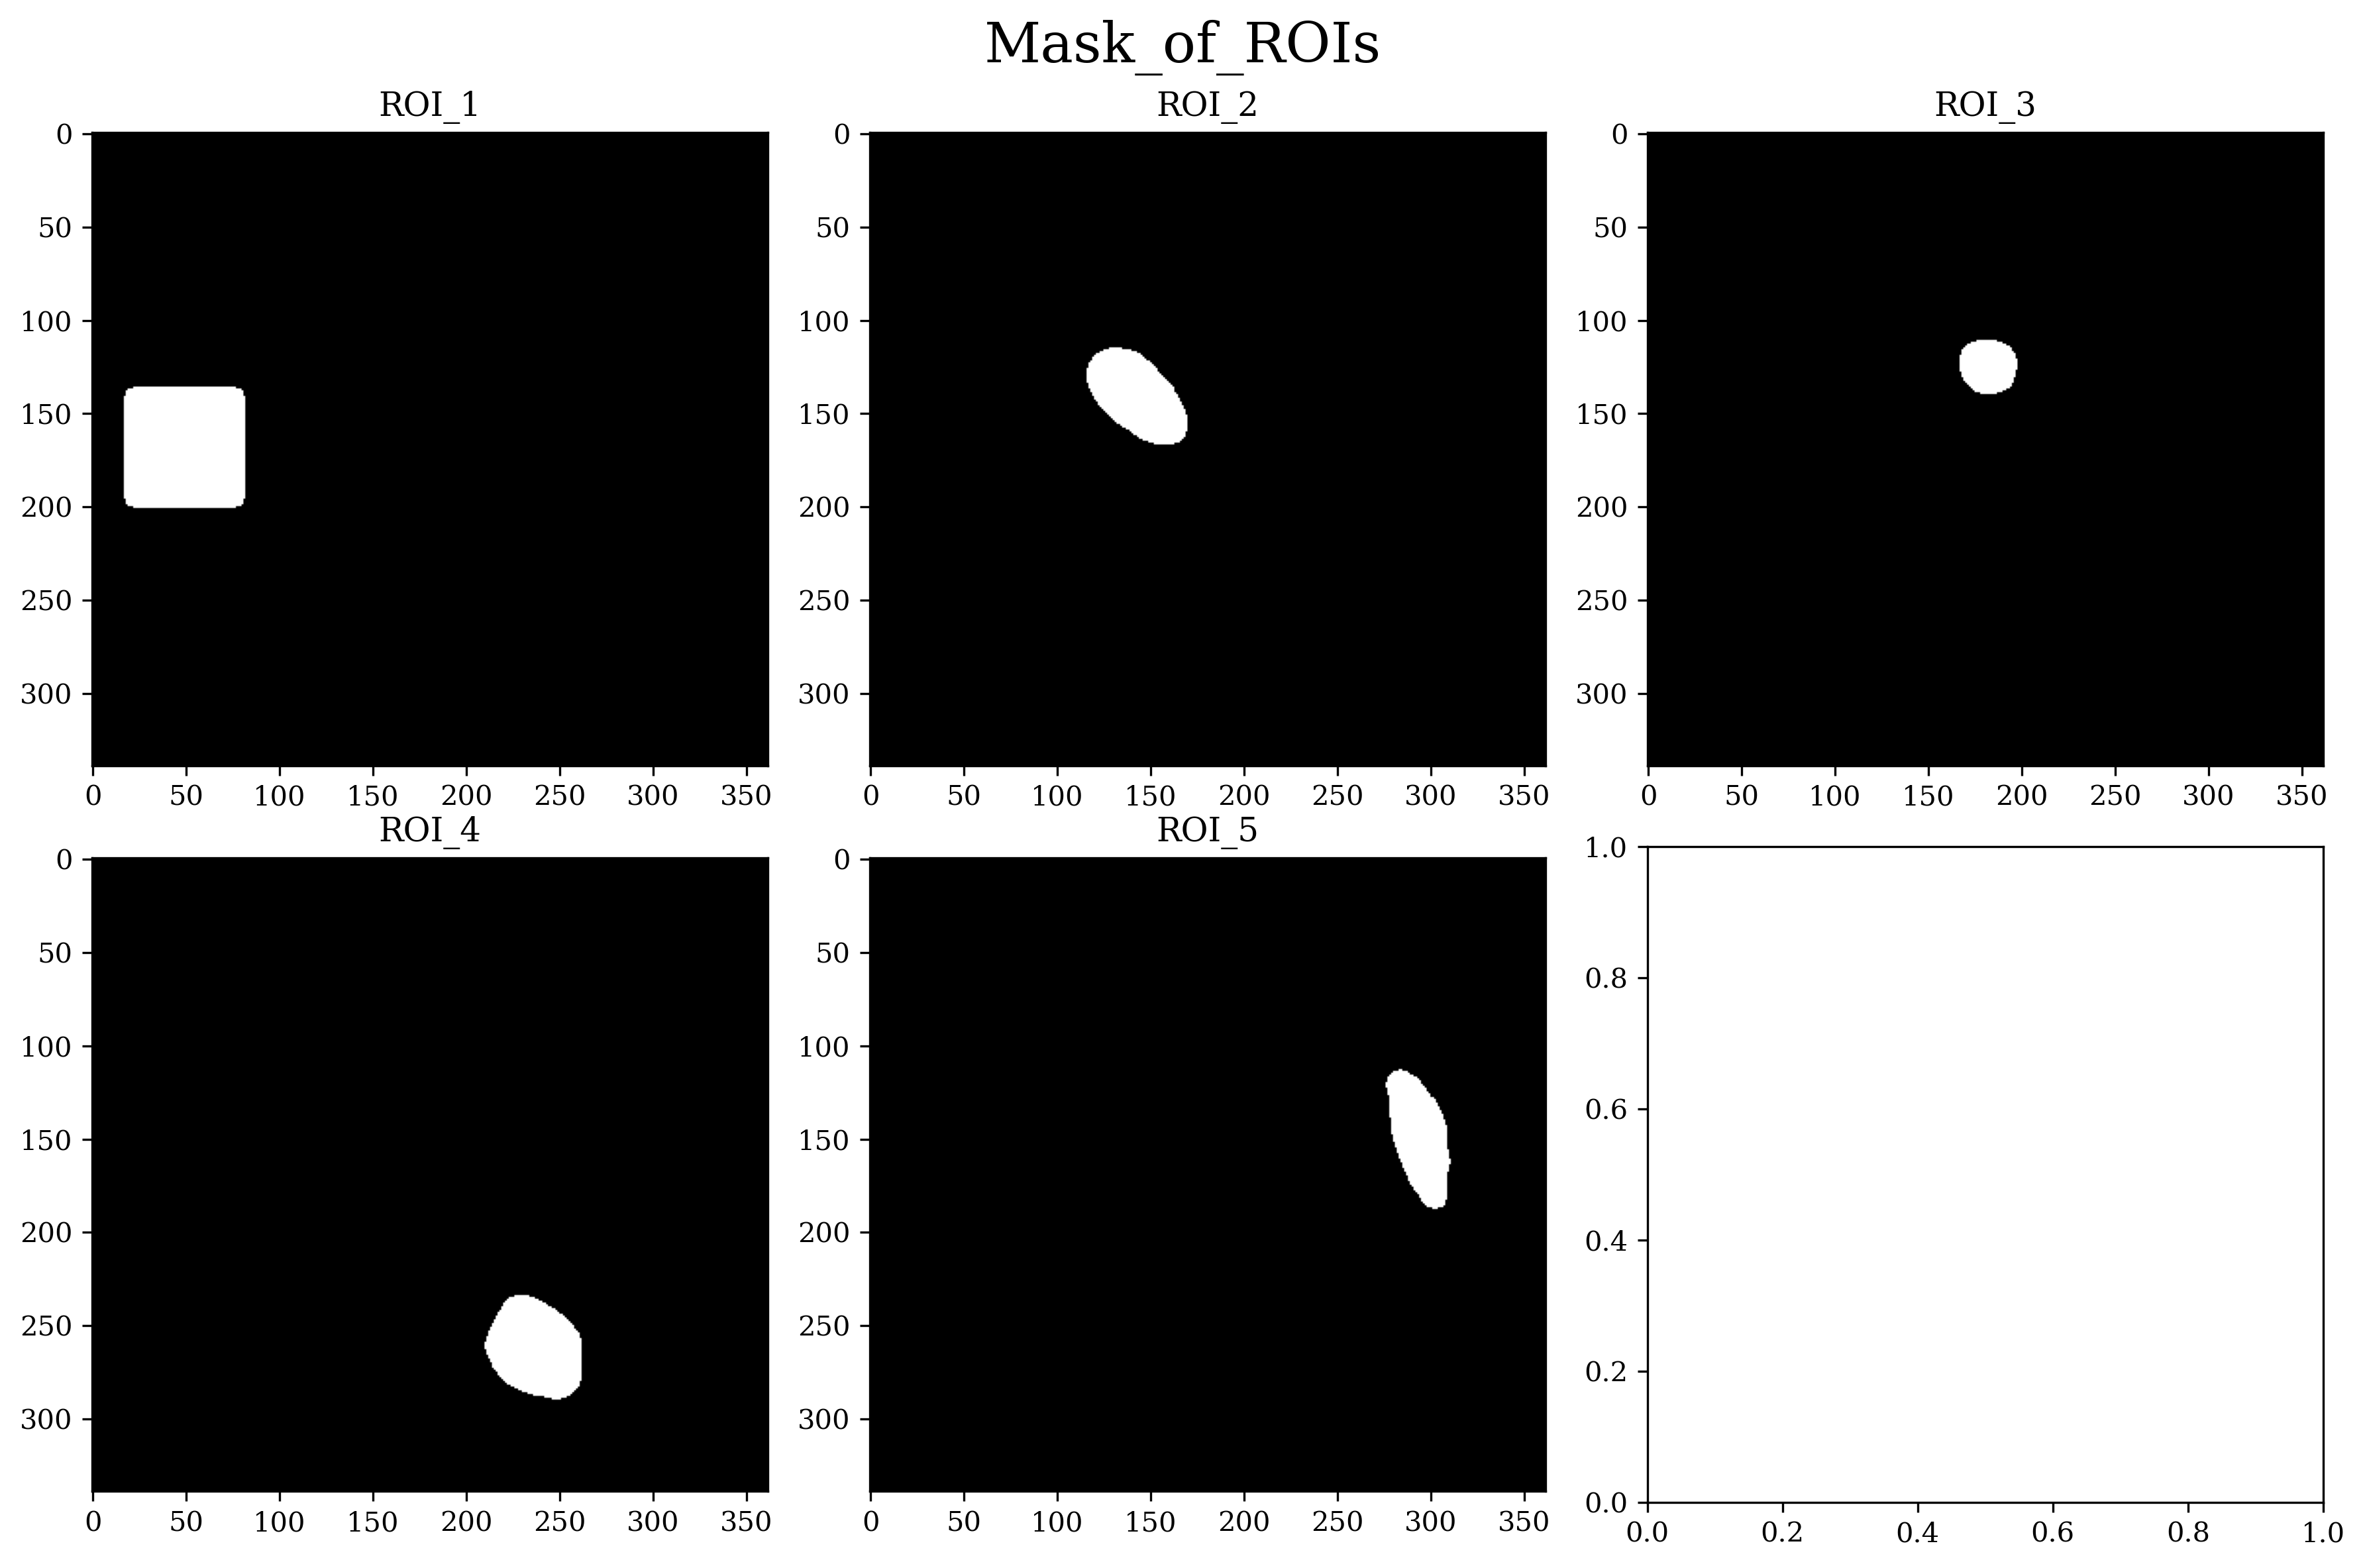

In [13]:
from skimage import io, transform, morphology

def ROI_mask_load(input_path, out_path, show=True, save=False):
    ROI_mask = {}
    for mask_file in os.listdir(input_path):
        image = io.imread(os.path.join(input_path, mask_file))
        image = transform.rotate(image, angle=90, resize=True)
        image = morphology.binary_dilation(image, footprint=morphology.disk(5))
        ROI_mask[mask_file.replace('.tif','').replace('Mask', 'ROI')] = image
        
    ncols = int(-(-len(ROI_mask)**(1/2)//1))
    nrows = -(-len(ROI_mask)//ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    for pos, mask_name in enumerate(list(ROI_mask.keys())):
        ax[pos // ncols][pos % ncols].imshow(ROI_mask[mask_name], cmap='gray')
        ax[pos // ncols][pos % ncols].set_title(mask_name)
        ax[pos // ncols][pos % ncols].set_xlabel("")
        ax[pos // ncols][pos % ncols].set_ylabel("")
    fig.suptitle('Mask_of_ROIs', fontsize=20)
    plt.tight_layout()

    if save: plt.savefig(out_path)
    if show: plt.show()
    plt.close()

    return ROI_mask

ROI_mask = ROI_mask_load(input_path=os.path.join(analysis_dir, 'roi_variation', 'roi_mask'), 
                         show=True, save=True, out_path=os.path.join(output_path, 'roi_mask.png'))

In [14]:
combine_adata_st = sc.read_h5ad(typ_path / 'combine_adata_st.h5ad')
adata_direct = sc.read_h5ad(typ_path / 'adata_leiden_res_1.h5ad')
adata = adata_direct[adata_direct.obs.index.isin(combine_adata_st.obs.index)]
adata.obs = combine_adata_st.obs

# format for later analysis
adata.obs = adata.obs.rename(columns={'X_pos':'X', 'Y_pos':'Y'})
adata.obsm['spatial'] = adata.obs.loc[:, ['X', 'Y']].values
adata.obs['batch'] = adata.obs['dataset']
adata = adata[adata.obs['type'] != 'other']

adata.obs['ROI'] = pd.Categorical(['other']*len(adata), categories=list(ROI_mask.keys()) + ['other'], ordered=False)    
for _, mask in ROI_mask.items():
    yrange = mask.shape[0]
    for cell in tqdm(adata.obs.index, desc=_):
        if mask[yrange - int(adata.obs['Y'].loc[cell]/100), int(adata.obs['X'].loc[cell]/100)]:
            adata.obs['ROI'].loc[cell] = _

print(adata)
adata.obs.head()

ROI_5: 100%|██████████| 60329/60329 [00:01<00:00, 57350.83it/s]

AnnData object with n_obs × n_vars = 60329 × 31
    obs: 'dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'type', 'leiden', 'sample', 'tissue', 'tmp_leiden', 'leiden_subtype', 'subtype', 'leiden_type', 'Y', 'X', 'batch', 'ROI'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


,dataset,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,n_genes,n_counts,type,leiden,sample,tissue,tmp_leiden,leiden_subtype,subtype,leiden_type,Y,X,batch,ROI
0,PRISM_HCC,9,2.302585,22.0,3.135494,9,22.0,Macrophage,0,NaN,non_liver,0,18,Macrophage_LYVE1+,11,1109,21214,PRISM_HCC,other
2,PRISM_HCC,10,2.397895,16.0,2.833213,10,16.0,Mast,13,NaN,non_liver,13,12,Mast_CPA3+,8,1156,21143,PRISM_HCC,other
4,PRISM_HCC,6,1.945910,7.0,2.079442,6,7.0,CD4+,28,NaN,non_liver,28,23,"T_CD4+, PD1+, CTLA4+",12,1164,21132,PRISM_HCC,other
5,PRISM_HCC,13,2.639057,41.0,3.737670,13,41.0,CD8+,45,NaN,non_liver,45,28,"T_CD8+, GZMA+, CXCL13+",13,1177,11828,PRISM_HCC,other
6,PRISM_HCC,10,2.397895,18.0,2.944439,10,18.0,Macrophage,0,NaN,non_liver,0,18,Macrophage_LYVE1+,11,1179,21227,PRISM_HCC,other


In [15]:
batches = {"2D": ["PRISM_HCC"]}
all_batches = list(np.concatenate(list(batches.values())))

Make the interaction graph, colored by celltype

In [ ]:
import yaml
with open(analysis_dir / 'cell_typing_params.yaml') as file:
    type_colormap = yaml.load(file, Loader=yaml.FullLoader)['type_colormap']
type_colormap

In [ ]:
# We have defined colors for the Type but not the Subtype annotation. Hence, we will create a assignment
# from subtype to type to pick the colors.
subtype_to_type = (adata.obs.groupby(["subtype", "type"]).size().reset_index().rename(columns={0: "count"}))
subtype_to_type = subtype_to_type[subtype_to_type["count"] > 0].set_index("subtype")

In [17]:
for roi in ROI_mask.keys():
    adata_tmp = adata[adata.obs['ROI'] == roi]
    figure_path = output_path / f'{roi}_interaction_graph'
    figure_path.mkdir(exist_ok=True)

    interaction_cutoff = 0.03
    gl = global_layout(adata=adata_tmp, cluster_key="subtype", batches=["PRISM_HCC"], interaction_cutoff=interaction_cutoff)
    
    for iter in range(21):
        interaction_cutoff = 0.01 * iter
        ncols = len(batches.keys())
        fig, axes = plt.subplots(1, ncols, figsize=(9 * ncols, 6 * 1))

        for col, batch in enumerate(batches.keys()):
            g = create_mean_interaction_graph(adata=adata_tmp, batches=batches[batch], cluster_key="subtype", interaction_cutoff=interaction_cutoff)
            if ncols == 1: ax = axes
            else: ax = axes[col]
            node_colors = [type_colormap[subtype_to_type["type"].loc[t]] for t in adata_tmp.obs["subtype"].cat.categories]
            try: plot_graph(g=g, vertex_colors=node_colors, ax=ax, layout=gl)
            except: continue
            ax.set_title(f"{batch}: subtype, interaction_cutoff={interaction_cutoff}")
        fig.tight_layout()
        plt.savefig(figure_path / f"subtype_interaction_graph_cutoff={iter}x0.01.png", bbox_inches='tight', dpi=300)
        plt.close()

## Figure 3c

In [ ]:
# gates = {
#     "Top": {
#         "edges": [
#             [0.15, 0.5],
#             [0.6, 0.7],
#             [0.8, 0.7],
#             [0.8, 1.03],
#             [0.15, 1.03],
#         ],
#         "label_position": {"x": 0.16, "y": 0.9},
#         "fill": "#3A9AB244",
#         "stroke": "#3A9AB2",
#     },
#     "Crypt": {
#         "edges": [
#             [0.15, 0.48],
#             [0.6, 0.68],
#             [0.8, 0.68],
#             [0.8, 0.25],
#             [0.2, 0],
#             [0.15, 0],
#         ],
#         "label_position": {"x": 0.16, "y": 0.05},
#         "fill": "#F11B0044",
#         "stroke": "#F11B00",
#     },
#     "Muscularis": {
#         "edges": [[0.22, 0], [0.8, 0.23], [6, 0.23], [6, 0], [0.22, 0]],
#         "label_position": {"x": 0.6, "y": 0.05},
#         "fill": "#BDC88155",
#         "stroke": "#BDC881",
#     },
# }

In [ ]:
# # Custom biexponential transformation.
# def transformation(x, a=0.1, b=0.1, c=0.5, d=2.5, f=4, w=1):
#     x = np.array(x)
#     return a * np.exp(b * ((x - w))) - c * np.exp(-d * (x - w)) + f


# def classify_cells(adata, gates, transformation=transformation):
#     """
#     Classify cells based on the IMAP gates.

#     Parameters:
#     - adata (anndata): The anndata object containing the cells to classify.
#     - gates (dict): A dictionary containing the gates to classify the cells with.
#     - transformation (function): A function to transform the x values of the gates.

#     Returns:
#     - result (geopandas dataframe): A geopandas dataframe containing the classified cells.
#     """
#     from shapely.geometry import Point
#     from shapely.geometry.polygon import Polygon
#     import geopandas as gpd

#     adata.obs["epithelial_distance_transformed"] = transformation(
#         adata.obs["epithelial_distance"]
#     )
#     adata.obs["gate"] = False

#     print("Creating polygons")
#     polygons = {}
#     for gate in gates:
#         # Apply transformation to x values
#         points = [
#             [transformation(element[0])] + element[1:]
#             for element in gates[gate]["edges"]
#         ]
#         polygons[gate] = Polygon(points)
#     polygons = gpd.GeoSeries(polygons)
#     gpd_poly = gpd.GeoDataFrame({"gates": polygons}, geometry="gates")

#     print("Creating cells")
#     cells = gpd.GeoSeries.from_xy(
#         adata.obs["epithelial_distance_transformed"], adata.obs["crypt_villi_axis"]
#     )
#     gpd_cells = gpd.GeoDataFrame({"cells": cells}, geometry="cells")

#     print("Joining cells and polygons")
#     result = gpd.sjoin(
#         gpd_cells,
#         gpd_poly,
#         how="left",
#     )
#     return result


# classification = classify_cells(adata, gates)
# classification

In [ ]:
# adata.obs["gate"] = classification["index_right"]

In [ ]:
# def make_name(gate, cell):
#     if cell == "Cd8_T-Cell_P14":
#         if gate == "Top":
#             return "P14 top"
#         elif gate == "Crypt":
#             return "P14 crypt"
#         elif gate == "Muscularis":
#             return "P14 muscularis"
#         else:
#             return "P14 undeterminded"
#     else:
#         return cell


# adata.obs["Subtype_gate"] = [
#     make_name(gate, cell) for gate, cell in zip(adata.obs["gate"], adata.obs["Subtype"])
# ]
# adata = adata[~(adata.obs["Subtype_gate"] == "P14 undeterminded")]
# adata.obs["Subtype_gate"] = adata.obs["Subtype_gate"].astype("category")

Heatmap for locations

In [ ]:
# # heatmap
# m = mean_interaction_matrix(adata, batches=all_batches, cluster_key="Subtype_gate")

In [ ]:
# population_of_intertest = ["P14 top", "P14 crypt", "P14 muscularis"]
# positions = [
#     list(adata.obs["Subtype_gate"].cat.categories).index(element)
#     for element in population_of_intertest
# ]
# m_p14 = m[positions]

In [ ]:
# # Scale each row from min to max
# scaler = MinMaxScaler()
# normalized_array = scaler.fit_transform(m_p14.T).T

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 1))
# sns.heatmap(
#     normalized_array,
#     xticklabels=adata.obs["Subtype_gate"].cat.categories,
#     yticklabels=population_of_intertest,
#     ax=ax,
#     cmap=colormap,
#     linecolor="white",
#     linewidths=0.5,
# )